# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

# Loading Data and Preliminaries

In [1]:
%cd /content/drive/MyDrive/TUe/DeepLearning/Assignment2

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/TUe/DeepLearning/Assignment2'
d:\Master\Y1\Deep learning\Deep-learning\assignment_2


In [2]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

In [3]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


# Data Handling and Preprocessing

In [4]:
def pad_array(data):
    # Pad the array with zeros if necessary to have 9 rows
    padded_input_data  = np.pad(data[0], ((0, 9 - data[0].shape[0]), (0, 0)), mode='constant')
    padded_target_data = np.pad(data[1], ((0, 9 - data[1].shape[0]), (0, 0)), mode='constant')
    return torch.tensor(padded_input_data, dtype=torch.float32), torch.tensor(padded_target_data, dtype=torch.float32)

def create_mask(data,padded_input_data):
    # Create a boolean mask array indicating the padded rows
    mask = np.ones_like(padded_input_data, dtype=bool)
    mask[data[0].shape[0]:] = False
    return torch.tensor(mask, dtype=torch.bool)

def pair_values(data):
    # Pair up the values of the same columns from every row with every other row
    num_rows, num_cols = data.shape
    padded_input_data = torch.zeros((num_rows, num_rows, num_cols, 2))

    for i in range(num_rows):
        pair_idx = 0
        for j in range(num_rows):

            padded_input_data[i, pair_idx, :, 0] = data[i]
            padded_input_data[i, pair_idx, :, 1] = data[j]
            pair_idx += 1

    return padded_input_data

def get_euclidean_distance(x):
    euclidean_distances = torch.zeros((len(x), len(x)))
    for i in range(len(x)):
        source_x, source_y= x[i][1], x[i][2]
        #euclidean_distance=[]
        for j in range(len(x)):
            target_x, target_y= x[j][1], x[j][2]
            euclidean_distances[i][j]=np.sqrt((source_x-target_x)**2+(source_y-target_y)**2)
            #euclidean_distance.append(np.sqrt((source_x-target_x)**2+(source_y-target_y)**2))
        #euclidean_distances.append(euclidean_distance)

    return euclidean_distances #list of lists

def target_difference(target_x, source_x):
    # target x and source x are of shape (9, 2)
    #Subtract the x and y coordinates of the target from the source
    return target_x - source_x


def process_file(file_path):
    # Main function to process a single file
    data = load_array(file_path, 'task 1')
    padded_input_data, padded_target_data = pad_array(data)
    mask = create_mask(data,padded_input_data)
    input_data = pair_values(padded_input_data)
    euclidean_distance = get_euclidean_distance(padded_input_data)
    target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

    return input_data, target_data, padded_input_data, mask, euclidean_distance


In [5]:
class CustomDataset_2(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.file_list = os.listdir(folder)

    def __len__(self):
        return len(self.file_list)

    def _read_file(self, file_path):
        input_data, target_data,data, mask, distances= process_file(file_path)
        return input_data, target_data,data, mask, distances

    def __getitem__(self, index):
        file_path = os.path.join(self.folder, self.file_list[index])
        # Read and preprocess the data from the file
        input_data, target_data,data, mask, distance = self._read_file(file_path)
        # Return the preprocessed data
        return input_data, target_data,data, mask, distance

# Model Implementation

## NPE implementation

In [6]:
class NPEEncoder(nn.Module):
    def __init__(self, hidden_units):
        super(NPEEncoder, self).__init__()
        self.pairwise_layer = nn.Linear(10, hidden_units, bias=False)
        self.feedforward = nn.Sequential(
            nn.Linear(hidden_units, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU(),
            nn.Linear(50, 50, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        x= x.to(torch.float32)
        x = self.pairwise_layer(x)
        x = self.feedforward(x)
        return x

class NPEDecoder(nn.Module):
    def __init__(self):
        super(NPEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(55, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [7]:
class NPEModel(nn.Module):
    def __init__(self, hidden_units, device):
        super(NPEModel, self).__init__()
        self.encoder = NPEEncoder(hidden_units)
        self.decoder = NPEDecoder()
        self.device = device

    def forward(self, x,unpaired_data, mask, distance, neighborhood_threshold=5):
        decoder_input = []
        dist_mask = ((distance > 0) & (distance < neighborhood_threshold))
        for batch in range(x.size(0)):
            batch_data= x[batch]
            for body in range(batch_data.size(0)):
                if torch.all(mask[batch][body]==1):
                    focus_body = unpaired_data[batch][body]

                    if dist_mask[batch][body].any():
                        chunk = torch.flatten(x[batch][body][dist_mask[batch][body]],start_dim=1)
                        neighbor_encodings = torch.sum(self.encoder(chunk), dim=0)
                    else:
                        neighbor_encodings = torch.zeros(50).to(self.device)
                    # Concatenate the focus body encoding with the focus_body
                    decoder_input.append(torch.cat((neighbor_encodings, focus_body), dim=0))
                else:
                    decoder_input.append(torch.cat((torch.zeros(50, device=self.device), torch.zeros_like(unpaired_data[batch][body])), dim=0))

        # Decode the concatenated vector
        decoded = self.decoder(torch.stack(decoder_input))

        out_shape = x.size()
        decoded = decoded.view(out_shape[0], out_shape[1], -1)

        return decoded

# Model Training

## NPE training

In [8]:
def load_data(folder):
    file_list = os.listdir(folder)
    output = []

    for filename in file_list:
        file_path = os.path.join(folder, filename)
        output.append(process_file(file_path))

    return output

In [9]:
data_dir = 'data/task 1/train'
# dataset = CustomDataset_2(data_dir)

dataset = load_data(data_dir)
train_dataset, valid_dataset = train_test_split(dataset, train_size=0.7) 


train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [10]:
test_data_dir = 'data/task 1/test'
# test_dataset = CustomDataset_2(test_data_dir)

test_dataset = load_data(test_data_dir)


test_data_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cpu')

In [12]:
# Hyperparameters
hidden_units = 25
learning_rate = 1e-3
learning_rate_decay = 0.99
iterations = 50
batch_size = 100

# Create the model
model = NPEModel(hidden_units, device=device)
model.to(device)
criterion = nn.MSELoss(reduction='none')
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [13]:
def train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion,
                    device=torch.device('cpu'), iterations=50, model_file='best_model.pth'):
    best_val_loss = np.inf
    for iteration in tqdm(range(iterations)):
        model.train()
        train_loss=0.0
        for input_data, target_data,unpaired_data, mask, distance in train_data_loader:
        # Training steps
            input_data = input_data.to(device)
            unpaired_data = unpaired_data.to(device)
            mask = mask.to(device)
            distance = distance.to(device)
            target_data=target_data.to(device)

            optimizer.zero_grad()
            output = model(input_data, unpaired_data, mask, distance)

            loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_data_loader)


        model.eval()
        test_loss=0.0
        with torch.no_grad():
            for input_data, target_data,unpaired_data, mask, distance in valid_data_loader:
                input_data = input_data.to(device)
                target_data = target_data.to(device)
                unpaired_data = unpaired_data.to(device)
                mask = mask.to(device)
                distance = distance.to(device)

                output = model(input_data, unpaired_data, mask, distance)
                loss = torch.masked_select(criterion(target_data, output),
                                       torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean()
                test_loss += loss.item()
        test_loss /= len(valid_data_loader)

        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save({
                'epoch': iteration+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, model_file)


            # Print loss for monitoring
            #if (iteration + 1) % 10000 == 0:
        print(f"Epoch [{iteration+1}/{iterations}], Loss: {train_loss}, \tTest Loss: {test_loss}")

In [14]:
train_sim_model(model, train_data_loader, test_data_loader, optimizer, criterion, device=device, iterations=iterations)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 13.985816383361817, 	Test Loss: 11.244125843048096
Epoch [2/50], Loss: 13.505384922027588, 	Test Loss: 10.31701135635376
Epoch [3/50], Loss: 11.745889568328858, 	Test Loss: 7.520480155944824
Epoch [4/50], Loss: 9.623817300796508, 	Test Loss: 6.42974853515625
Epoch [5/50], Loss: 8.792934703826905, 	Test Loss: 6.128693342208862
Epoch [6/50], Loss: 8.435100030899047, 	Test Loss: 6.139812469482422
Epoch [7/50], Loss: 8.380176162719726, 	Test Loss: 5.854802846908569
Epoch [8/50], Loss: 8.078586006164551, 	Test Loss: 5.513668775558472
Epoch [9/50], Loss: 7.704919290542603, 	Test Loss: 5.280551433563232
Epoch [10/50], Loss: 7.498129367828369, 	Test Loss: 5.014339923858643
Epoch [11/50], Loss: 7.184095001220703, 	Test Loss: 4.788589954376221
Epoch [12/50], Loss: 6.900307607650757, 	Test Loss: 4.6405580043792725
Epoch [13/50], Loss: 6.804527330398559, 	Test Loss: 4.441267013549805
Epoch [14/50], Loss: 6.376402568817139, 	Test Loss: 4.390193939208984
Epoch [15/50], Loss: 6.13

## Evaluation task 1

In [15]:
def get_MSE(data_loader,model):
    MSE_total = 0
    MSE_data = []

    model.eval()
    with torch.no_grad():
        num_points = len(data_loader.dataset)
        for input_data, target_diff, unpaired_data, mask, distance in data_loader:
            
                
                predicted_change = model(input_data, unpaired_data, mask, distance)

                mask_stack = torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)

                MSE_data_batch = criterion(target_diff, predicted_change) * mask_stack.float()
                
                MSE_total += torch.masked_select(criterion(target_diff, predicted_change),
                                        torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean() * len(unpaired_data)/num_points
            
                
                MSE_data.append([MSE_data_batch, unpaired_data, target_diff])

    return MSE_total, MSE_data

In [16]:
valid_MSE, valid_MSE_data = get_MSE(valid_data_loader,model)

In [17]:
test_MSE, test_MSE_data = get_MSE(test_data_loader, model)

In [18]:
train_MSE, train_MSE_data = get_MSE(train_data_loader, model)

In [19]:
first_batch_MSE = test_MSE_data[0]
first_batch_MSE = [[val.mean() for val in batch] for batch in first_batch_MSE[0]]
first_batch_MSE = [torch.stack(val).mean() for val in first_batch_MSE]

In [20]:
sorted_indexes = torch.argsort(torch.stack(first_batch_MSE))
top_3 = sorted_indexes[:3]
min_3 = sorted_indexes[-3:]


In [21]:
print("Indexes of the three lowest MSE scores:", top_3)
print("Indexes of the three highest MSE scores:", min_3)

Indexes of the three lowest MSE scores: tensor([17, 18, 54])
Indexes of the three highest MSE scores: tensor([16, 24,  5])


In [22]:
def plot(model, test_data_loader, indexes):
    model.eval()
    
    num_plots = len(indexes)
    num_cols = 3  # Number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), squeeze=False)  # Create the subplot grid
    
    
    for i, index in enumerate(indexes):
        row = i // num_cols  # Calculate the row index
        col = i % num_cols  # Calculate the column index

        ax = axes[row, col] if num_plots > 1 else axes  # Select the appropriate subplot

        with torch.no_grad():
            input_data, target_diff, unpaired_data, mask, distance = test_data_loader.dataset[index]

            input_data = input_data.unsqueeze(0)
            unpaired_data = unpaired_data.unsqueeze(0)
            mask = mask.unsqueeze(0)
            distance = distance.unsqueeze(0)

            output = model(input_data, unpaired_data, mask, distance)
            init_pos = test_data_loader.dataset[index][2][:, 1:3]
            mass = unpaired_data[:, :, :1]

            predicted_pos = init_pos + output 
            gt = init_pos + test_data_loader.dataset[index][1]

            for j in range(init_pos.shape[0]):
                init_pos_body = init_pos[j]
                predicted_pos_body = predicted_pos[0][j]
                gt_body = gt[j]
                mass_body = mass[0][j]

                # Assign a unique color to each body
                color = plt.cm.tab10(j)

                # Calculate dot size based on mass value
                dot_size = mass_body * 3

                # plot x vs y for this body, with different styles for ground truth and prediction
                ax.plot(gt_body[0], gt_body[1], 'o-', label=f'Body {j} Ground Truth', color=color, markersize=dot_size)
                ax.plot(predicted_pos_body[0], predicted_pos_body[1], 'o--', label=f'Body {j} Predicted',
                        color=color, markersize=dot_size)

                # Draw lines connecting initial position, ground truth, and predicted positions
                ax.plot([init_pos_body[0], gt_body[0]], [init_pos_body[1], gt_body[1]], '-', color=color)
                ax.plot([init_pos_body[0], predicted_pos_body[0]], [init_pos_body[1], predicted_pos_body[1]], '--',
                        color=color)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if i < 4:
            ax.set_title('Trajectories failure cases')
        else:
            ax.set_title('Trajectories succesful cases')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.55, hspace=0.1)
    plt.show()



In [23]:
indexes = torch.cat((min_3, top_3), dim=0)

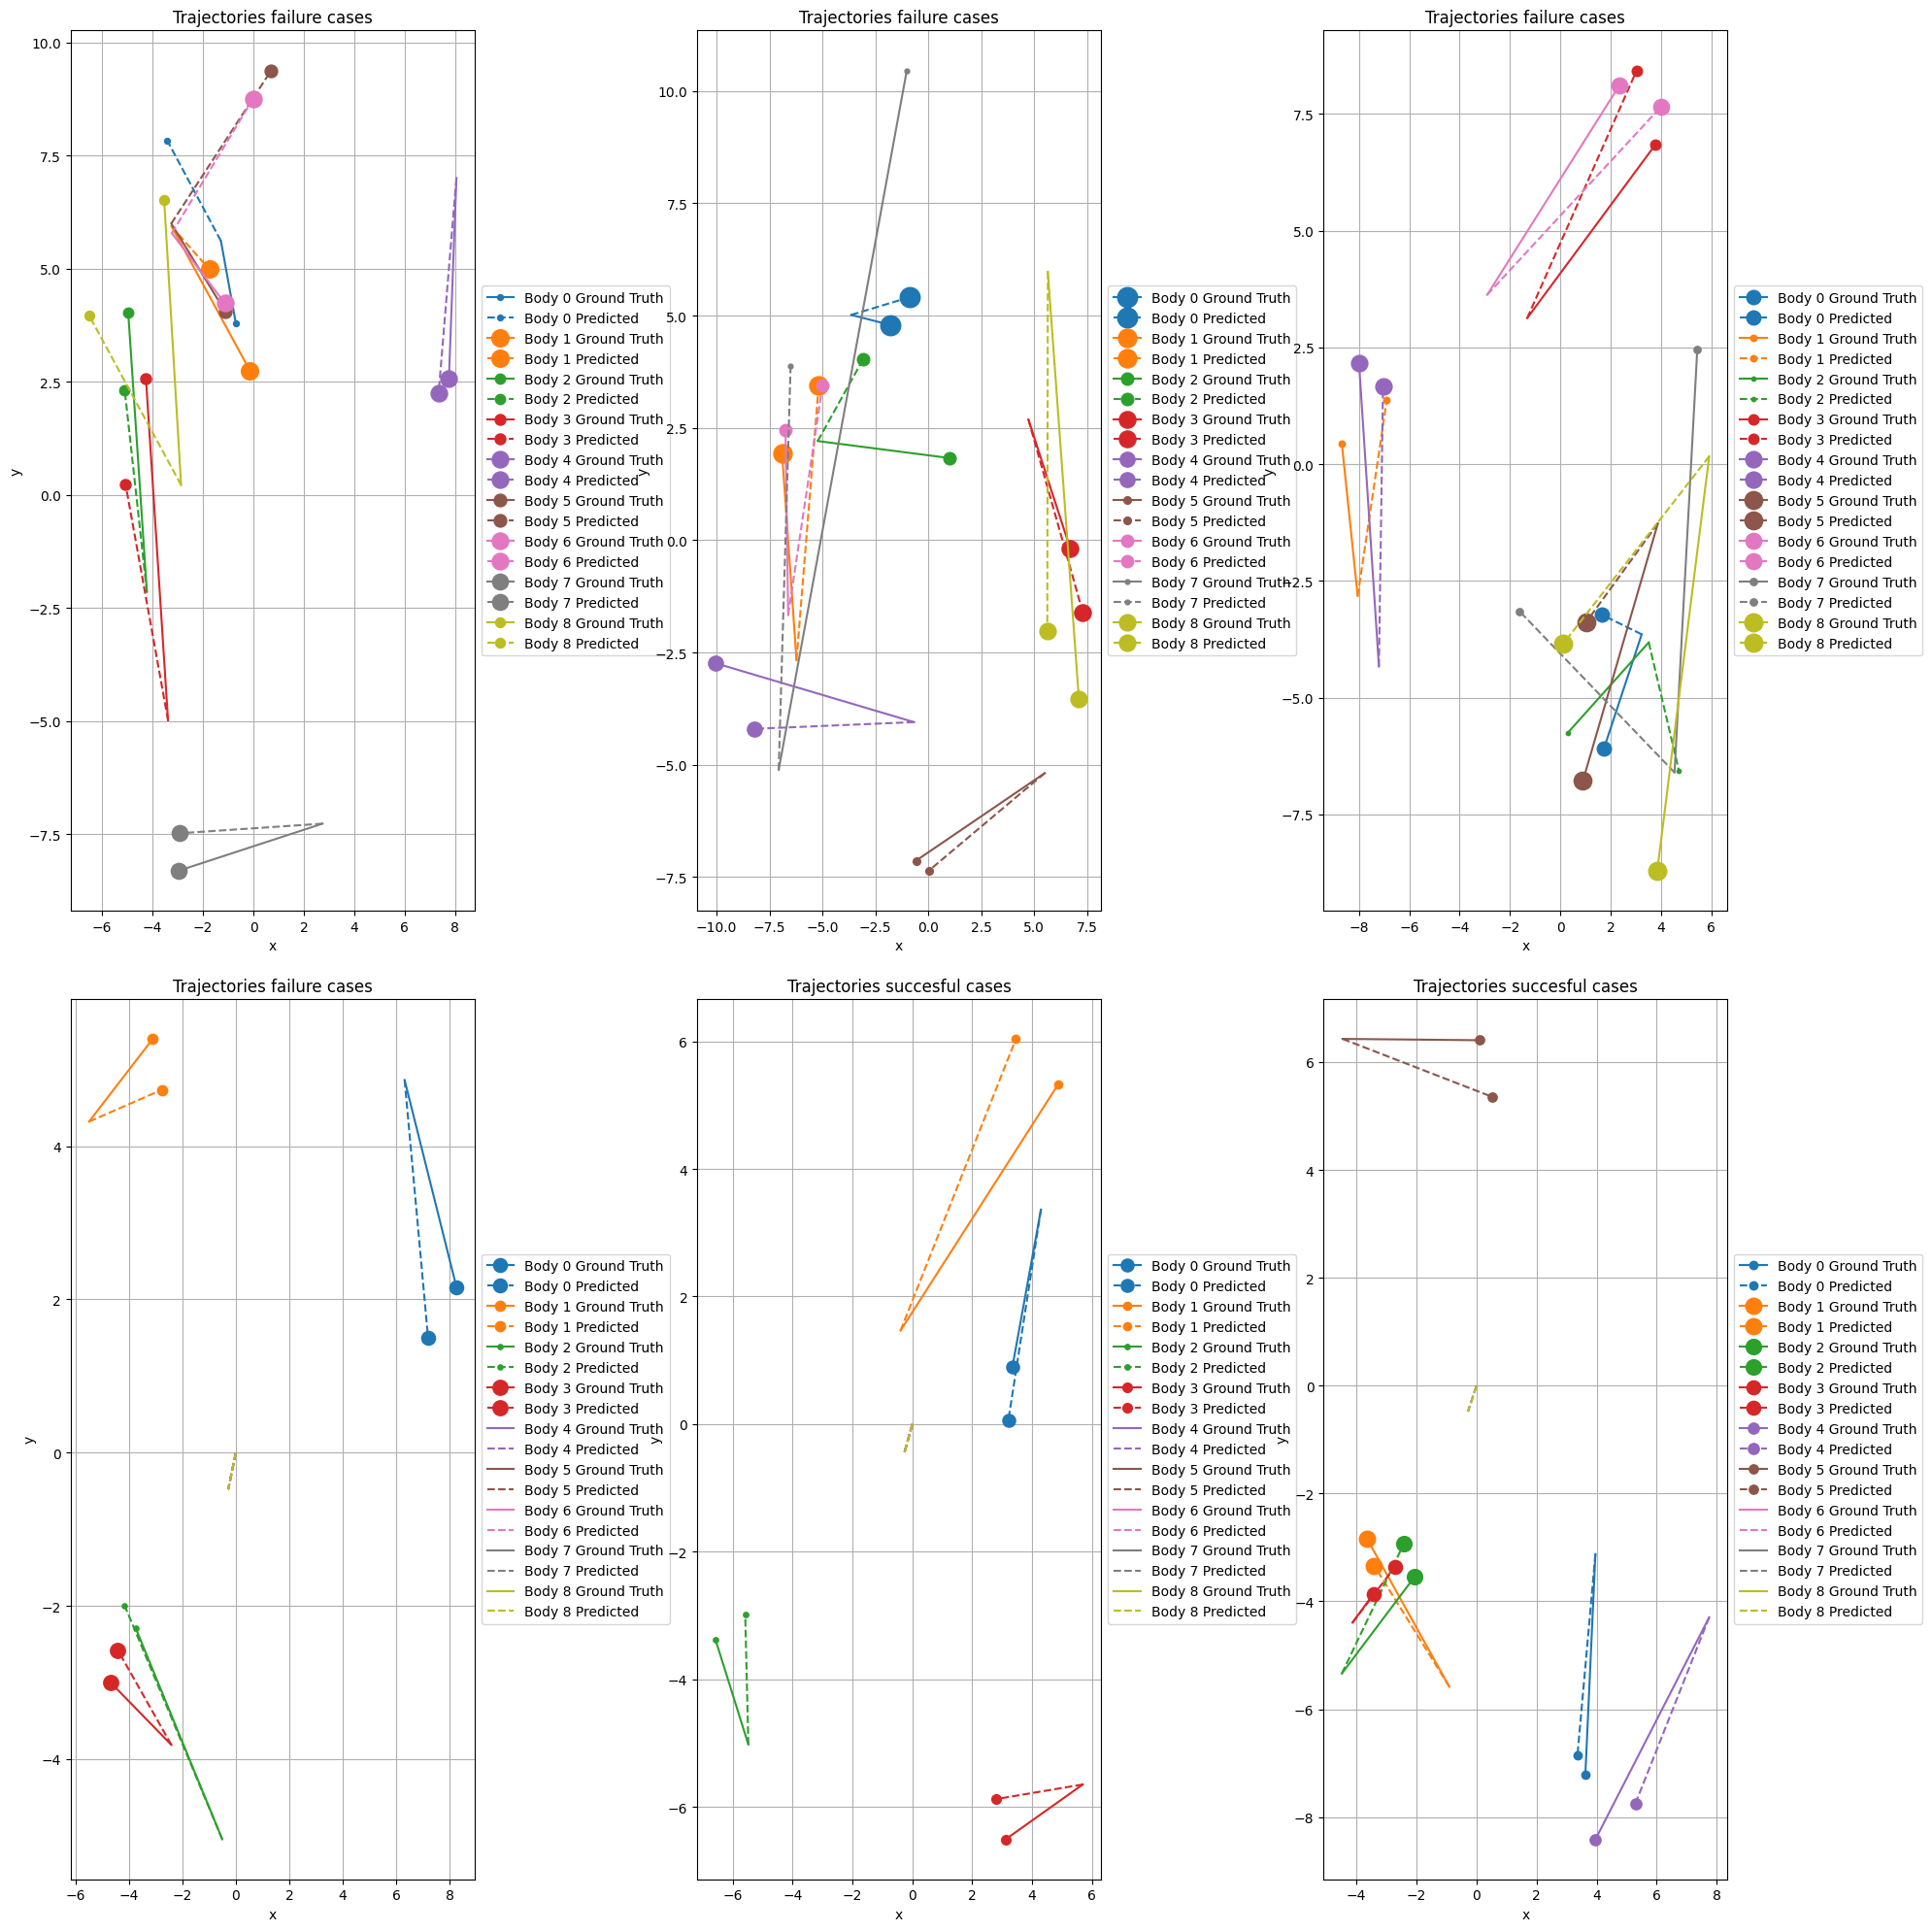

In [24]:
plot(model, test_data_loader, indexes)

## Eval to baseline

In [25]:
def get_MSE_baseline(data_loader, t):
    MSE_total_base = 0
    MSE_total_const = 0

    num_points = len(data_loader.dataset)
    for input_data, target_diff, unpaired_data, mask, distance in data_loader:
        
        target = unpaired_data[:, :, 1:3] + target_diff
        predicted_pos_base = unpaired_data[:, :, 1:3] + unpaired_data[:,:,3:5] * t
        predicted_pos_const = unpaired_data[:, :, 1:3]

        mask_stack = torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)
        
        MSE_total_base += torch.masked_select(criterion(target, predicted_pos_base),
                                torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean() * len(unpaired_data)/num_points
        MSE_total_const += torch.masked_select(criterion(target, predicted_pos_const),
                                torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean() * len(unpaired_data)/num_points
 

    return MSE_total_base, MSE_total_const

In [26]:
MSE_total_base_test, MSE_total_const_test = get_MSE_baseline(test_data_loader, 5)
MSE_total_base_train, MSE_total_const_train = get_MSE_baseline(train_data_loader, 5)
MSE_total_base_val, MSE_total_const_val = get_MSE_baseline(valid_data_loader, 5)
valid_MSE, train_MSE, test_MSE

(tensor(4.2166), tensor(3.6283), tensor(3.2045))

In [27]:
from tabulate import tabulate

table_data = [
    ["Model", "Train MSE", "Validation MSE", "Test MSE"],
    ["Baseline linear", MSE_total_base_train, MSE_total_base_val, MSE_total_base_test],
    ["Constant", MSE_total_const_train, MSE_total_const_val, MSE_total_const_test],
    ["NPE", train_MSE, valid_MSE, test_MSE]
]

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print(table)


╒═════════════════╤═════════════╤══════════════════╤════════════╕
│ Model           │   Train MSE │   Validation MSE │   Test MSE │
╞═════════════════╪═════════════╪══════════════════╪════════════╡
│ Baseline linear │    22.423   │         21.603   │   20.3079  │
├─────────────────┼─────────────┼──────────────────┼────────────┤
│ Constant        │    14.1394  │         13.5112  │   11.4935  │
├─────────────────┼─────────────┼──────────────────┼────────────┤
│ NPE             │     3.62834 │          4.21663 │    3.20451 │
╘═════════════════╧═════════════╧══════════════════╧════════════╛


# Task 2

In [28]:
def files_2_data(files):
    output = []
    for file_path in tqdm(files):
        datapoint = np.load(file_path)
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        for i in range(whole_trajectory.shape[1] - 1):
            data = whole_trajectory[:, i], whole_trajectory[:, i + 1, 1:3]
            padded_input_data, padded_target_data = pad_array(data)
            mask = create_mask(data,padded_input_data)
            input_data = pair_values(padded_input_data)
            euclidean_distance = get_euclidean_distance(padded_input_data)
            target_data= target_difference(padded_target_data, padded_input_data[:,1:3])

            output.append((input_data, target_data, padded_input_data, mask, euclidean_distance))
    return output

In [29]:
files_rate = 1.0

train_files = glob('data/task 2_3/train/*')
train_files = train_files[:int(len(train_files) * files_rate)]

train_files, valid_files = train_test_split(train_files, train_size=0.7)

In [32]:
train_data = files_2_data(train_files)

valid_data = files_2_data(valid_files)

  0%|          | 0/270 [00:00<?, ?it/s]

In [33]:
BATCH_SIZE = 256

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [35]:
# Hyperparameters
hidden_units = 25
LR = 1e-3
EPOCHS = 20

# Create the model
model = NPEModel(hidden_units, device=device).to(device)

criterion = nn.MSELoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [83]:
train_sim_model(model, train_data_loader, valid_data_loader, optimizer, criterion, device, iterations=10, model_file='best_task2_model.pth')

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
def recalc_data(padded_input_data):
    input_data = []
    euclidean_distance = []
    for elem in padded_input_data:
        input_data.append(pair_values(elem))
        euclidean_distance.append(get_euclidean_distance(elem))

    return torch.stack(input_data), padded_input_data, torch.stack(euclidean_distance)

In [47]:
def simulate(init_data, times=4):
    input_data, unpaired_data, mask, distance = init_data

    input_data = input_data.to(device)
    unpaired_data = unpaired_data.to(device)
    mask = mask.to(device)
    distance = distance.to(device)

    locations = []
    # locations = locations.to(device)
    model.eval()
    with torch.no_grad():
        for time in range(times):
            
            output = model(input_data, unpaired_data, mask, distance)
        
            unpaired_data[:,:,3:5] = output
            unpaired_data[:,:,1:3] += unpaired_data[:,:,3:5]
            locations.append(unpaired_data[:,:,1:3][0].clone())
            
           
            input_data, unpaired_data, distance = recalc_data(unpaired_data)

    return locations

# Evaluation Task 2

In [84]:
model_path = 'npe_10epoch_05data.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [192]:
def files_2_data_test(files):
    output = []
    for file_path in tqdm(files):
        _, target = load_array(file_path, 'task 2')
        target = target[:,0:5,0:2] #get relevant info
        output.append(np.transpose(target, (1, 0, 2))) #reshape to desired targets
    return output

In [194]:
test_targets = files_2_data_test(test_files)

  0%|          | 0/100 [00:00<?, ?it/s]

In [195]:
test_files = glob('data/task 2_3/test/*')
test_data = files_2_data(test_files)

  0%|          | 0/100 [00:00<?, ?it/s]

In [196]:
BATCH_SIZE = 1

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

In [197]:
def eval_model_2(data_loader, targets):

    model.eval()
    test_loss=0.0
    count = 0
    outputs = []

    with torch.no_grad():
        num_points = len(data_loader.dataset)
        for input_data, target_data, unpaired_data, mask, euclidean_distance in data_loader:
            
            if count % 49 == 0:
                unpaired_data[torch.isnan(unpaired_data)] = 0

                input_data[torch.isnan(input_data)] = 0
                
                system = input_data, unpaired_data, mask, euclidean_distance
        
                output = simulate(system)
                outputs.append(output)
                
                target_data = [target_data for _, (_, target_data, _, _, _) in zip(range(4), data_loader.dataset[count:count+5])]
                
                output = torch.stack(output)
                # target_data = [torch.from_numpy(val) for val in target_data]
    
                target_data = torch.stack(target_data)
                target_padded = torch.tensor([np.pad(tensor, ((0, 9 - tensor.shape[0]), (0, 0)), mode='constant') for tensor in target_data])
                # print(target_padded)
            
              
                loss = torch.masked_select(criterion(target_padded, output),
                                    torch.stack([mask.all(dim=2), mask.all(dim=2)], dim=2)).mean() 
             
                # print(target_padded)
    
                # print(output)
            
                test_loss += loss 
                break


            count += 1
    test_loss /= int(count/49)

    return test_loss

In [198]:
targets_test = files_2_data_test(test_files)
MSE_test_2 = eval_model_2(test_data_loader, targets_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [101]:
targets_train[1]

array([[[ 6.11836655,  2.44632713],
        [ 7.35649438, -2.09408896],
        [-5.56606272, -4.59554031],
        [-1.20126612, -6.69565726]],

       [[ 6.15008653,  2.41134048],
        [ 7.34947845, -2.1108288 ],
        [-5.5878929 , -4.54509585],
        [-1.24422423, -6.65960782]],

       [[ 6.18192467,  2.3751226 ],
        [ 7.34176742, -2.12596872],
        [-5.60901818, -4.49470948],
        [-1.28783098, -6.6227054 ]],

       [[ 6.21387582,  2.3376583 ],
        [ 7.33336717, -2.13948207],
        [-5.6294363 , -4.44438616],
        [-1.33208767, -6.58494505]]])

In [104]:
targets_valid = files_2_data_test(valid_files)
# MSE_valid_2 = eval_model_2(valid_data_loader, targets_valid)

  0%|          | 0/270 [00:00<?, ?it/s]

[[[ 6.02760743e+00  1.03608413e+00 -3.65521828e-01 -4.63862657e-02]
  [ 5.98951426e+00  1.03144168e+00 -3.96465109e-01 -4.65271763e-02]
  [ 5.94828755e+00  1.02676487e+00 -4.28214697e-01 -4.70831602e-02]
  [ 5.90383975e+00  1.02200908e+00 -4.60912211e-01 -4.81187897e-02]
  [ 5.85606807e+00  1.01712252e+00 -4.94721931e-01 -4.97129003e-02]
  [ 5.80485190e+00  1.01204467e+00 -5.29836910e-01 -5.19624953e-02]
  [ 5.75004956e+00  1.00670419e+00 -5.66487072e-01 -5.49880488e-02]
  [ 5.69149412e+00  1.00101620e+00 -6.04950140e-01 -5.89408378e-02]
  [ 5.62898785e+00  9.94878760e-01 -6.45566678e-01 -6.40132890e-02]
  [ 5.56229498e+00  9.88168022e-01 -6.88761235e-01 -7.04539252e-02]
  [ 5.49113187e+00  9.80731598e-01 -7.35072818e-01 -7.85895371e-02]
  [ 5.41515347e+00  9.72379163e-01 -7.85200061e-01 -8.88591143e-02]
  [ 5.33393413e+00  9.62868751e-01 -8.40070360e-01 -1.01867688e-01]
  [ 5.24693966e+00  9.51886090e-01 -9.00949876e-01 -1.18475529e-01]
  [ 5.15348514e+00  9.39012041e-01 -9.69626767e-

In [103]:
targets_train = files_2_data_test(train_files)
MSE_train_2 = eval_model_2(train_data_loader, targets_train)

  0%|          | 0/630 [00:00<?, ?it/s]

[[[ 1.52993468e+00  2.04563422e+00  1.07532204e+00 -9.58162731e-02]
  [ 1.63770543e+00  2.03559856e+00  1.08011630e+00 -1.04918375e-01]
  [ 1.74596273e+00  2.02464605e+00  1.08505425e+00 -1.14155534e-01]
  [ 1.85472133e+00  2.01276248e+00  1.09014367e+00 -1.23541781e-01]
  [ 1.96399677e+00  1.99993221e+00  1.09539234e+00 -1.33092446e-01]
  [ 2.07380537e+00  1.98613796e+00  1.10080807e+00 -1.42824275e-01]
  [ 2.18416421e+00  1.97136071e+00  1.10639859e+00 -1.52755537e-01]
  [ 2.29509117e+00  1.95557954e+00  1.11217153e+00 -1.62906161e-01]
  [ 2.40660485e+00  1.93877144e+00  1.11813431e+00 -1.73297868e-01]
  [ 2.51872460e+00  1.92091114e+00  1.12429406e+00 -1.83954325e-01]
  [ 2.63147045e+00  1.90197090e+00  1.13065757e+00 -1.94901302e-01]
  [ 2.74486311e+00  1.88192027e+00  1.13723111e+00 -2.06166857e-01]
  [ 2.85892386e+00  1.86072589e+00  1.14402031e+00 -2.17781519e-01]
  [ 2.97367452e+00  1.83835122e+00  1.15103001e+00 -2.29778508e-01]
  [ 3.08913735e+00  1.81475625e+00  1.15826409e+

In [79]:
len(train_data_loader)/49

630.0

In [77]:
MSE_train_2

tensor(38.4232, dtype=torch.float64)